In [1]:
dir_path = "/kaggle/input/trashnet/dataset-resized"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import urllib
import itertools
import random, os, glob
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [3]:
target_size = (224, 224)
waste_labels = {"cardboard":0, "glass":1, "metal":2, "paper":3, "plastic":4, "trash":5}

In [4]:
def load_dataset(path):
  x = []
  labels = []
  image_paths = sorted(list(paths.list_images(path)))
  for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    x.append(img)
    label = image_path.split(os.path.sep)[-2]
    labels.append(waste_labels[label])
  x, labels = shuffle(x, labels, random_state=42)
  input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
  print("X shape: ", np.array(x).shape)
  print(f"Number of Labels: {len(np.unique(labels))} , Number of Observation: {len(labels)}")
  print("Input Shape: ", input_shape)
  return x, labels, input_shape

In [5]:
x, labels, input_shape = load_dataset(dir_path)

X shape:  (2527, 224, 224, 3)
Number of Labels: 6 , Number of Observation: 2527
Input Shape:  (224, 224, 3)


In [6]:
def visualizeation_img(image_batch, labels, num_of_img):
  plt.figure(figsize=(10,10))
  for n in range(num_of_img):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=len(np.unique(labels)))[n] == 1][0].title())
    plt.axis("off")

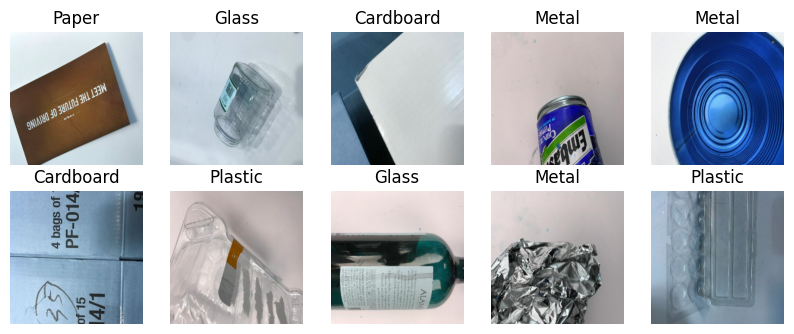

In [7]:
visualizeation_img(x, labels, 10)

In [8]:
def CNN_data_preparation():
  train = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1,
                             rescale=1./255,
                             shear_range=0.1,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
  test = ImageDataGenerator(rescale=1/255, validation_split=0.1)
  train_generator = train.flow_from_directory(directory=dir_path,
                                              target_size=(target_size),
                                              class_mode="categorical",
                                              subset="training")
  test_generator = test.flow_from_directory(directory=dir_path,
                                            target_size=(target_size),
                                            batch_size=251,
                                            class_mode="categorical",
                                            subset="validation")
  return train_generator, test_generator

train_generator, test_generator = CNN_data_preparation()

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Hàm xây dựng Connector 1
def connector_1(input_tensor):
    x = layers.Conv2D(filters=input_tensor.shape[-1], kernel_size=(3, 3), padding="same")(input_tensor)
    x = layers.AveragePooling2D(pool_size=(1, 1))(input_tensor)
    x = layers.Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([input_tensor, x])

# Hàm xây dựng Connector 2
def connector_2(input_tensor):
    x = layers.Conv2D(filters=input_tensor.shape[-1], kernel_size=(3, 3), padding="same")(input_tensor)
    x = layers.Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([input_tensor, x])

# Feature Extraction Module
def feature_extraction_module(input_tensor):
    #Block1
    x = layers.Conv2D(16, (7, 7), padding='same', activation=None)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(16, (7, 7), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.AveragePooling2D((2, 2))(x)  # 224x224 -> 112x112
    #Block2
    x = layers.Conv2D(32, (5, 5), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.AveragePooling2D((2, 2))(x)
    
    x = connector_1(x)  # Thêm connector 1
    #Block3
    x = layers.Conv2D(64, (4, 4), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.AveragePooling2D((2, 2))(x)
    
    x = connector_1(x)  # Thêm connector 1
    #Block4
    x = layers.Conv2D(128, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.AveragePooling2D((2, 2))(x)
    
    x = connector_1(x)  # Thêm connector 1
    #Block5
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.DepthwiseConv2D(6, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = connector_2(x)  # Thêm connector 2

    return x

# Classification Module
def classification_module(input_tensor, num_classes=6):
    x = layers.GlobalAveragePooling2D()(input_tensor)
    x = layers.Dense(num_classes, activation="softmax")(x)
    return x

# Xây dựng mô hình tổng thể
def build_model(input_shape=(224, 224, 3), num_classes=6):
    inputs = layers.Input(shape=input_shape)
    x = feature_extraction_module(inputs)
    outputs = classification_module(x, num_classes=num_classes)
    model = models.Model(inputs, outputs)
    return model

# Tạo và kiểm tra mô hình
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 16)   │          2,368 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 224, 224, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 16)   │         12,560 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 224, 224, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 112, 112, 16)   │              0 │ re_lu_1[0][0]          │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 32)   │         12,832 │ average_pooling2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 112, 112, 32)   │            320 │ re_lu_2[0][0]          │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 32)   │            128 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 112, 112, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_1       │ (None, 56, 56, 32)     │              0 │ re_lu_3[0][0]          │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_2       │ (None, 56, 56, 32)     │              0 │ average_pooling2d_1[0… │
│ (AveragePooling2D)   

 Total params: 1,126,358 (4.30 MB)

 Trainable params: 1,123,414 (4.29 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [10]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') and logs.get('accuracy')>=0.90) :
            print('\n reached 90 % accuracy so counceling training')
            self.model.stop_training = True

callback = MyCallback()

In [11]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Huấn luyện mô hình
history=model.fit(train_generator, epochs=300,batch_size = 16, validation_data=test_generator)#, callbacks=[callback])

Epoch 1/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 87s 803ms/step - accuracy: 0.4521 - loss: 1.5892 - val_accuracy: 0.2351 - val_loss: 1.8955
Epoch 2/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 326ms/step - accuracy: 0.5582 - loss: 1.1651 - val_accuracy: 0.2351 - val_loss: 2.0630
Epoch 3/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 330ms/step - accuracy: 0.6229 - loss: 0.9953 - val_accuracy: 0.2351 - val_loss: 1.9128
Epoch 4/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 316ms/step - accuracy: 0.6490 - loss: 0.9909 - val_accuracy: 0.2351 - val_loss: 1.9130
Epoch 5/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.6808 - loss: 0.8804 - val_accuracy: 0.1873 - val_loss: 2.6296
Epoch 6/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 330ms/step - accuracy: 0.6674 - loss: 0.9491 - val_accuracy: 0.3147 - val_loss: 2.2126
Epoch 7/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 331ms/step - accuracy: 0.7088 - loss: 0.8065 - val_accuracy: 0.2709 - val_loss: 2.7584
Epoch 8/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 332ms/step - accuracy: 0.7367 - loss: 0.7741 - 

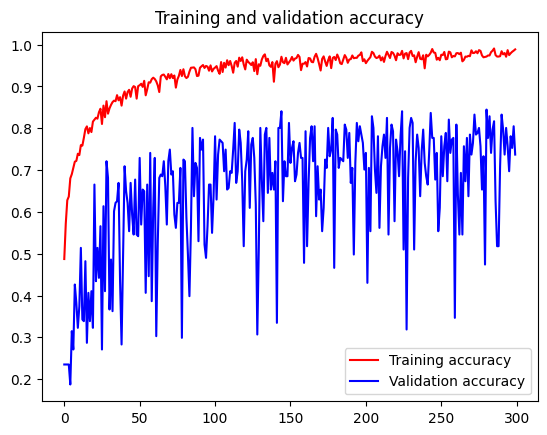

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [14]:
model.save("/kaggle/working/save_model.h5")


In [15]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/save_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


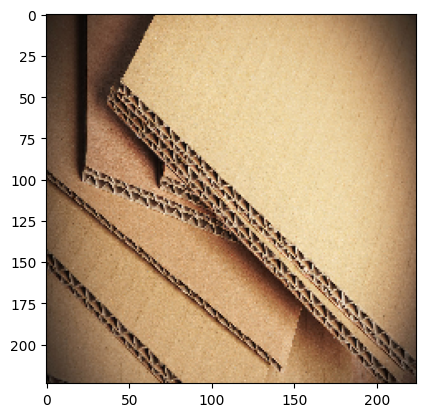

Predictions: [[1.0000000e+00 1.0897881e-15 3.4086366e-08 1.1471026e-08 7.3270699e-18
  3.2514671e-14]]
Predicted Class Index: 0
Predicted Label: cardboard


In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class_labels = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Load ảnh và resize về kích thước đúng
img = load_img('/kaggle/input/helpme/double_wall_corrugated_1000x664.jpg', target_size=(224, 224))  # Resize ảnh về (224, 224)
img_array = img_to_array(img)  # Chuyển đổi ảnh thành mảng numpy
img_array = img_array / 255.0  # Chuẩn hóa giá trị pixel về [0, 1]
img_array = img_array.reshape(1, 224, 224, 3)  # Thêm batch dimension
img.show()
# Dự đoán với mô hình
predictions = model.predict(img_array)
# Lấy chỉ số của lớp có xác suất cao nhất
predicted_class_index = np.argmax(predictions)
predicted_label = class_labels[predicted_class_index]

plt.imshow(img)
plt.axis('on')
plt.show()

print("Predictions:", predictions)
print("Predicted Class Index:", predicted_class_index)
print("Predicted Label:", predicted_label)
